# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.


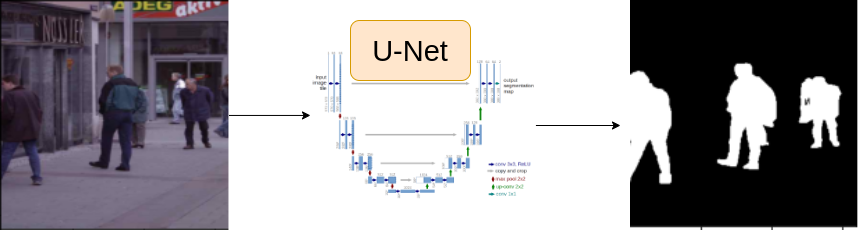

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [19]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [11]:
row = df.iloc[2]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

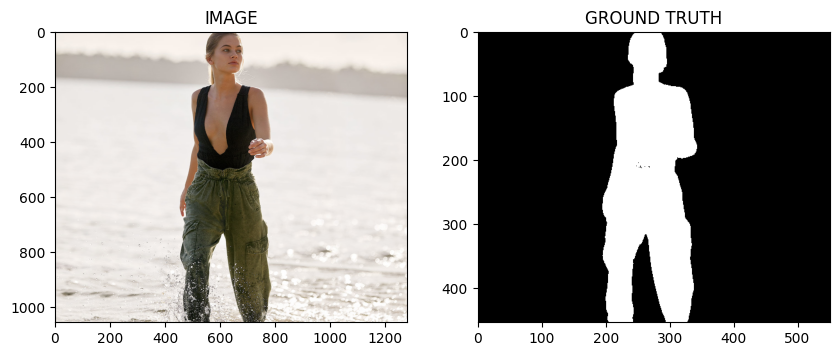

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [13]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [108]:
import albumentations as A

In [109]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [110]:
from torch.utils.data import Dataset

In [111]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2,0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)) / 255.0

    return image, mask

In [112]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [113]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


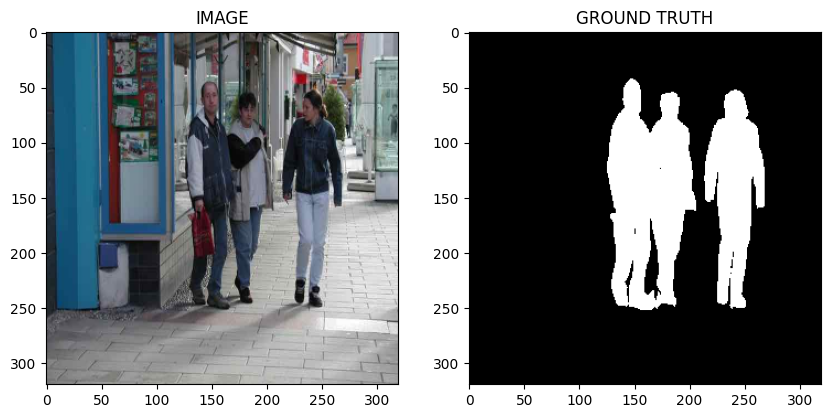

In [115]:
idx = 42

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [116]:
from torch.utils.data import DataLoader

In [117]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [118]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [120]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [134]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [135]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None,
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits,  loss1+loss2

    return logits


In [136]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [137]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for image, masks in tqdm(data_loader):

    image = image.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(image, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [138]:
def eval_fn(data_loader, model, optimizer):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for image, masks in tqdm(data_loader):

      image = image.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(image, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [139]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [140]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model, optimizer)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Best Model!")
    best_valid_loss = valid_loss


  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Saved Best Model!
Epoch : 1
Train Loss : 0.6764874637126923
Valid Loss : 6.922273278236389


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Saved Best Model!
Epoch : 2
Train Loss : 0.37430771986643474
Valid Loss : 0.6204051300883293


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Saved Best Model!
Epoch : 3
Train Loss : 0.3144998828570048
Valid Loss : 0.25852637737989426


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch : 4
Train Loss : 0.2658273488283157
Valid Loss : 0.3942534998059273


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 5
Train Loss : 0.22643441359202068
Valid Loss : 0.2902880683541298


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch : 6
Train Loss : 0.24513303438822429
Valid Loss : 0.2599659487605095


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Saved Best Model!
Epoch : 7
Train Loss : 0.17274161378542582
Valid Loss : 0.2119176797568798


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Saved Best Model!
Epoch : 8
Train Loss : 0.16626057277123132
Valid Loss : 0.20436954870820045


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch : 9
Train Loss : 0.18826099038124083
Valid Loss : 0.23772218078374863


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 10
Train Loss : 0.23225601613521576
Valid Loss : 0.23805315792560577


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Saved Best Model!
Epoch : 11
Train Loss : 0.19376301169395446
Valid Loss : 0.19451186805963516


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 12
Train Loss : 0.17232437133789064
Valid Loss : 0.24708625674247742


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch : 13
Train Loss : 0.16601501802603405
Valid Loss : 0.19749115407466888


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 14
Train Loss : 0.1451648399233818
Valid Loss : 0.22500839829444885


100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Saved Best Model!
Epoch : 15
Train Loss : 0.13300106624762217
Valid Loss : 0.1814960539340973


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Saved Best Model!
Epoch : 16
Train Loss : 0.14430305014053982
Valid Loss : 0.17400960996747017


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch : 17
Train Loss : 0.11397529890139897
Valid Loss : 0.19130191579461098


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 18
Train Loss : 0.15006708949804307
Valid Loss : 0.18320507556200027


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 19
Train Loss : 0.11566171695788702
Valid Loss : 0.17958993092179298


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


Saved Best Model!
Epoch : 20
Train Loss : 0.10653180380662282
Valid Loss : 0.17183800041675568


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Saved Best Model!
Epoch : 21
Train Loss : 0.09084203392267227
Valid Loss : 0.16561978682875633


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch : 22
Train Loss : 0.09823638846476873
Valid Loss : 0.183701079338789


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Epoch : 23
Train Loss : 0.10268977681795756
Valid Loss : 0.1758063081651926


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch : 24
Train Loss : 0.09145572433869044
Valid Loss : 0.19002565927803516


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

Saved Best Model!
Epoch : 25
Train Loss : 0.09004126489162445
Valid Loss : 0.15933162719011307


# Task 9 : Inference

In [145]:
idx  = 30

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask =validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

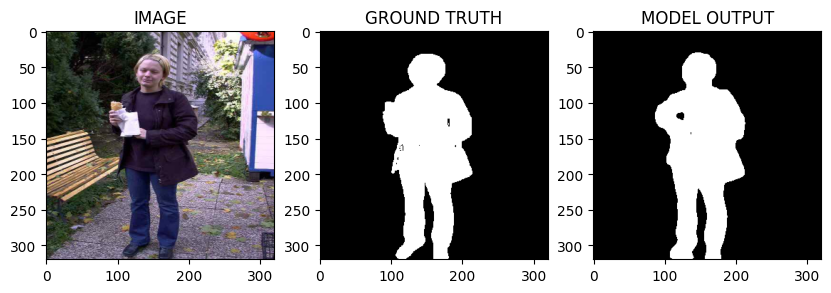

In [146]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya